# Finding Charity Donors
## Machine Learning (Supervised): Classification


### Description

This project will employ several supervised algorithms to accurately model individuals income using data collected from the 1994 U.S. Census. The best algorithm from preliminary results will be further optimized for the best model of the data. The goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  

### Project Goals
- **Target: Which potential donors make over $50,000?**
- How to identify when preprocessing is needed, and how to apply it.
- How to establish a benchmark for a solution to the problem.
- What each of several supervised learning algorithms accomplishes given a specific dataset.
- How to investigate whether a candidate solution model is adequate for the problem


### References
- [Kohavi: Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf)
- [Charity ML Dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income)

## Load Libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from time import time
from IPython.display import display 
from tensorflow.python.client import device_lib

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV

import seaborn as sns
sns.set(style="dark")
sns.set(font_scale=1.5)

%matplotlib inline

#import visuals as vs
%run ./visuals.py

print('Python:',sys.version)
print ('GPU:',device_lib.list_local_devices()[1].physical_device_desc,device_lib.list_local_devices()[1].name)

Python: 3.6.3 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:27:45) [MSC v.1900 64 bit (AMD64)]
GPU: device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1 /device:GPU:0


## Data Summary

In [27]:
df = pd.read_csv("census.csv")
y_raw = df['income']
X_raw = df.drop('income', axis = 1)

print('Dataframe Shape:',df.shape)
display(df.head())
display(df.describe())
display(df.dtypes)

Dataframe Shape: (45222, 14)


,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


age                  int64
workclass           object
education_level     object
education-num      float64
marital-status      object
occupation          object
relationship        object
race                object
sex                 object
capital-gain       float64
capital-loss       float64
hours-per-week     float64
native-country      object
income              object
dtype: object

In [28]:
n_records = len(df)
n_greater_50k = df[df['income'] == '>50K'].shape[0]
n_at_most_50k = df[df['income'] == '<=50K'].shape[0]
greater_percent = (n_greater_50k / n_records) * 100

print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


## Exploratory Visualization

### Scatter Matrix

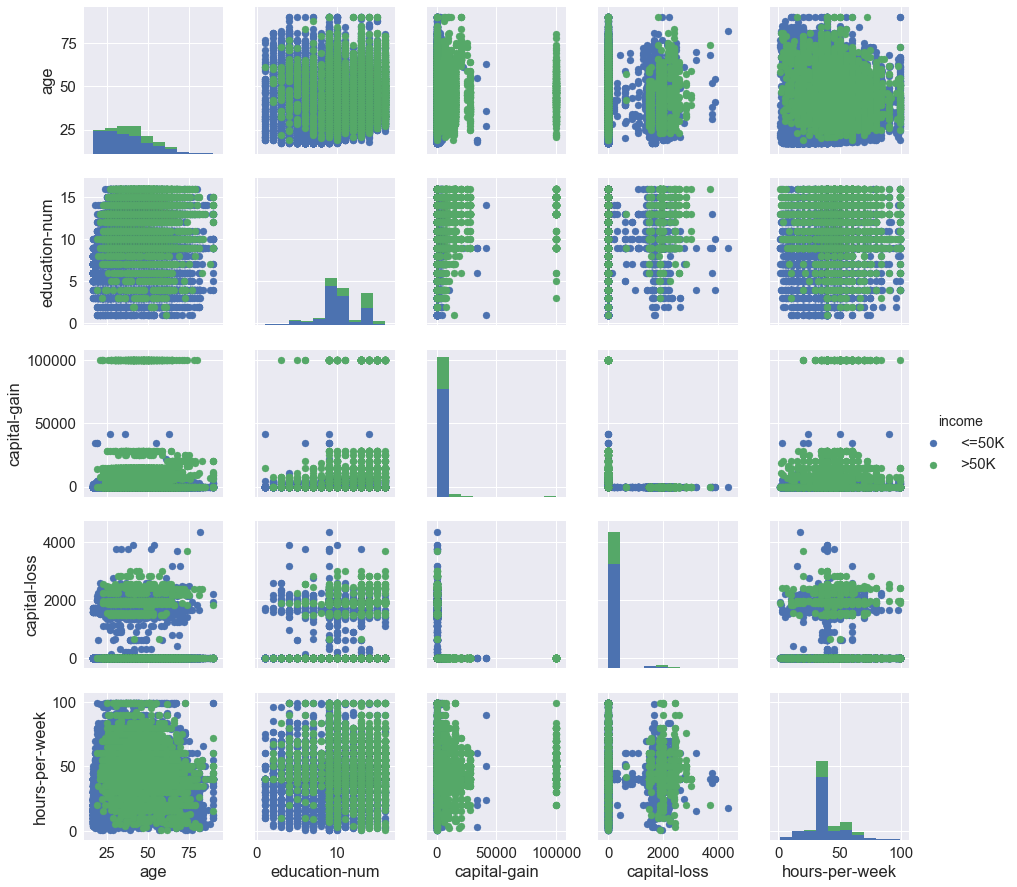

In [29]:
g = sns.PairGrid(df, hue="income")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

### Kernel Density Estimation Plots

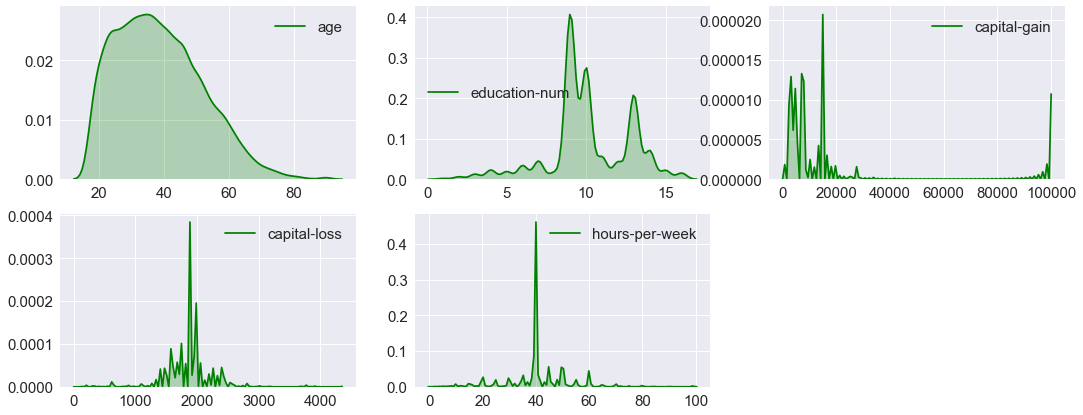

In [30]:
num_columns = df.select_dtypes(exclude=['object']).columns
fig = plt.figure(figsize=(18,7))
for i, col in enumerate(num_columns):
    fig.add_subplot(2, 3, i+1)
    sns.kdeplot(df[col], shade=True, color='g')
plt.show()

## Preprocessing

### Transforming Skewed Continuous Features

,after,before
age,0.532816,0.532816
education-num,-0.310621,-0.310621
capital-gain,3.082386,11.789002
capital-loss,4.271195,4.516304
hours-per-week,0.340545,0.340545


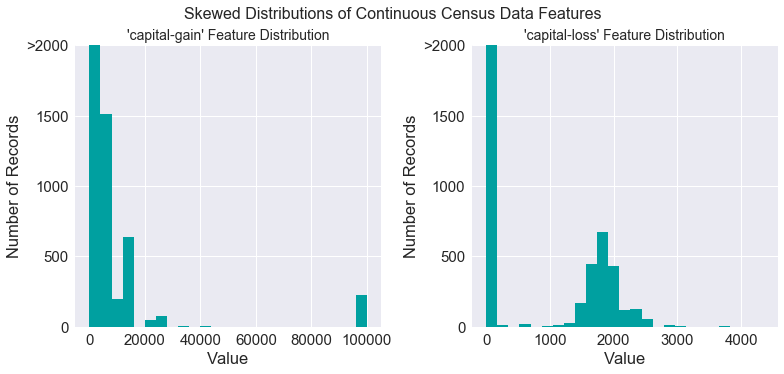

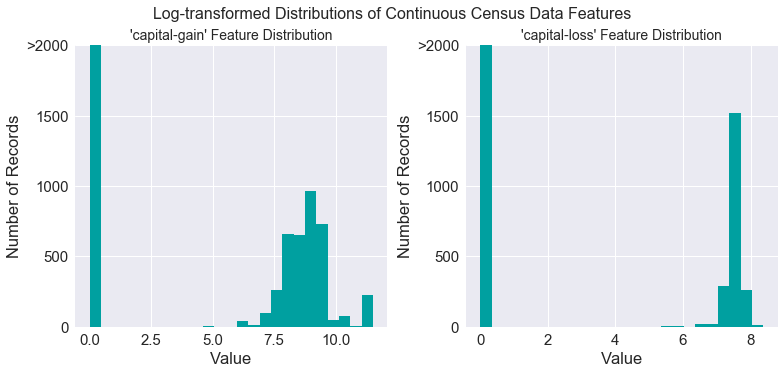

In [31]:
skewed = ['capital-gain', 'capital-loss']

X_log_transformed = X_raw.copy(deep=True)
X_log_transformed[skewed] = X_log_transformed[skewed].apply(lambda x: np.log(x + 1))

distribution(X_raw[skewed])
distribution(X_log_transformed[skewed], transformed = True)
display(pd.DataFrame({'before': X_raw.skew(), 'after': X_log_transformed.skew()}))

#X_raw.loc[0, 'age'] = 99

### Normalizing Numerical Features

In [32]:
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

scaler = MinMaxScaler()
X_log_minmax_transform = X_log_transformed.copy(deep = True)
X_log_minmax_transform[numerical] = scaler.fit_transform(X_log_transformed[numerical])

#display(X_log_minmax_transform.head())
#display(X_log_minmax_transform.describe())

### Converting Categorical Features using One Hot Encoding and Lambda Function

In [33]:
X = pd.get_dummies(X_log_minmax_transform)
y = y_raw.apply(lambda x: 1 if x == '>50K' else 0)

#from sklearn.preprocessing import LabelEncoder
#encoder = LabelEncoder()
#income = encoder.fit_transform(income_raw)

print('Dataframe Shape (after encoding):',X.shape,'\n')
#for feat in X_final.columns: print (feat)

print(y.value_counts())

Dataframe Shape (after encoding): (45222, 103) 

0    34014
1    11208
Name: income, dtype: int64


### Shuffle and Split Data into Training and Testing Datasets

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print ('Dataframe Shape (Training):',X_train.shape, y_train.shape)
print ('Dataframe Shape (Testing):',X_test.shape, y_test.shape)

Dataframe Shape (Training): (36177, 103) (36177,)
Dataframe Shape (Testing): (9045, 103) (9045,)


## Model Performance

The model's ability to **precisely** predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals.

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

When $\beta = 0.5$, more emphasis is placed on **precision**. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

** Note: **The purpose of generating a naive predictor is simply to show what a base model without any intelligence would look like. In the real world, ideally your base model would be either the results of a previous model or could be based on a research paper upon which you are looking to improve. When there is no benchmark model set, getting a result better than random choice is a place you could start from.

### Naive Predictor: Benchmark for Results

In [51]:
y_pred = y.apply(lambda x: 1) # naive prediction ==> benchmark for results
#y_pred = [1 for i in range(len(y))] 

### Performance Metric: fbeta_score (beta = 0.5)

In [52]:
scoring = make_scorer(fbeta_score, beta=0.5)

TP = np.sum(y)
FP = y.count() - TP
TN = 0
FN = 0

accuracy = TP / (TP + FP)
recall = TP / (TP + FN)
precision = TP / (TP + FP)
beta = 0.5
fscore = (1 + beta**2) * ((precision * recall) / ((beta**2 * precision) + recall))

print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Random Forest Classifier

- **This model should provide solid results**
- application (real world):  predicting behavior in e-commerce
- strengths: very good for high dimensional spaces and robust to outliers
- weaknesses: structure of the results is difficult to interpret
- [Random Forest Classifier](https://en.wikipedia.org/wiki/Random_forest)

### AdaBoost Classifier

- **This is a strong model with generally high levels of accuracy**
- application (real world):  face detection
- strengths: very robust, does not need lots of tuning unlike other models
- weaknesses: possibly overfits with pink noise
- [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost)

### Gradient Boosting Classifier

- **This strng model should provide even better results with increased training time**
- application (real world):  predicting behavior in medicine
- strengths: generally higher accuracy than random forest
- weaknesses: much more computationally expensive
- [Gradient Boosting Classifier](https://en.wikipedia.org/wiki/Gradient_boosting)

## Learning Curve

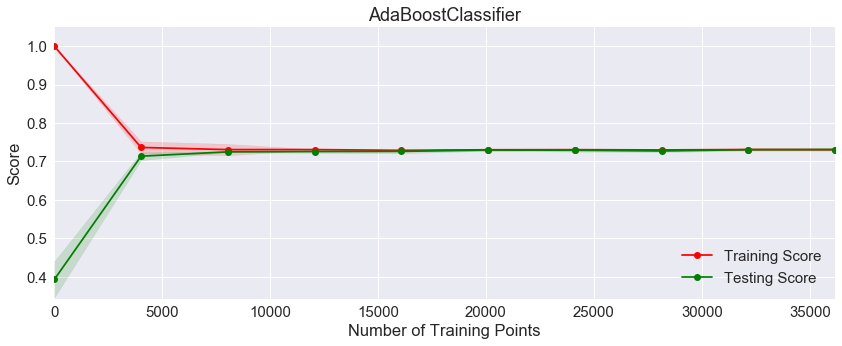

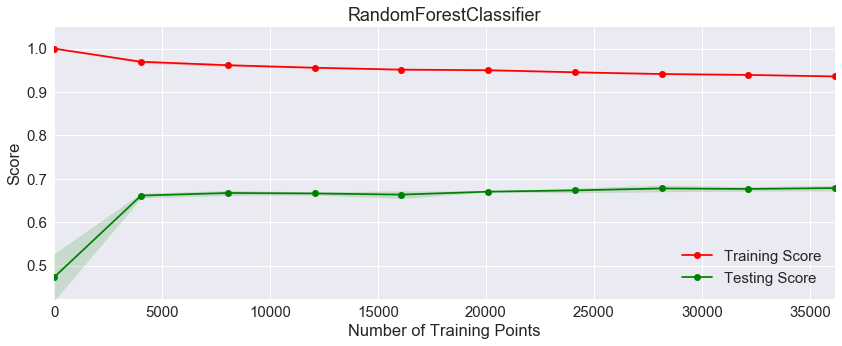

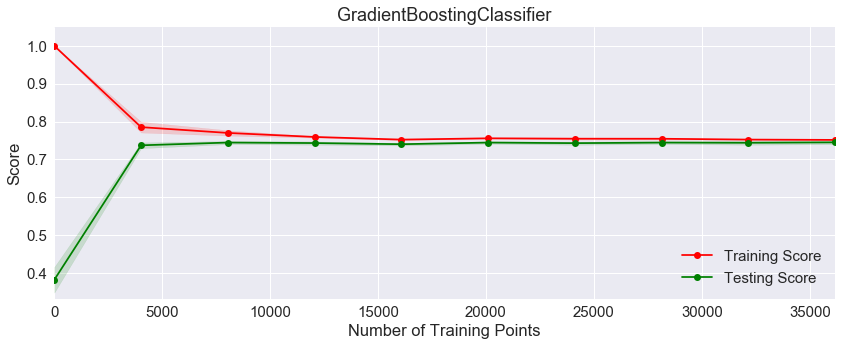

Wall time: 2min 39s


In [47]:
%%time

cv = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 0)
train_sizes = np.rint(np.linspace(10, X.shape[0]*0.8 - 1, 10)).astype(int)

ModelLearning(X, y, RandomForestClassifier(random_state = 0), cv, scoring, train_sizes)
ModelLearning(X, y, AdaBoostClassifier(random_state = 0), cv, scoring, train_sizes)
ModelLearning(X, y, GradientBoostingClassifier(random_state = 0), cv, scoring, train_sizes)

## Dimensionality Reduction

- AdaBoost will be used for Dimensionality Reduction. This algorithm is fast with a high level of accuracy.
- Reducing dimensions from 103 to 27 reduces the training time for the Model Pipeline by 50%

Dataframe Shape (after dimensionality reduction): (36177, 27)
Wall time: 832 ms


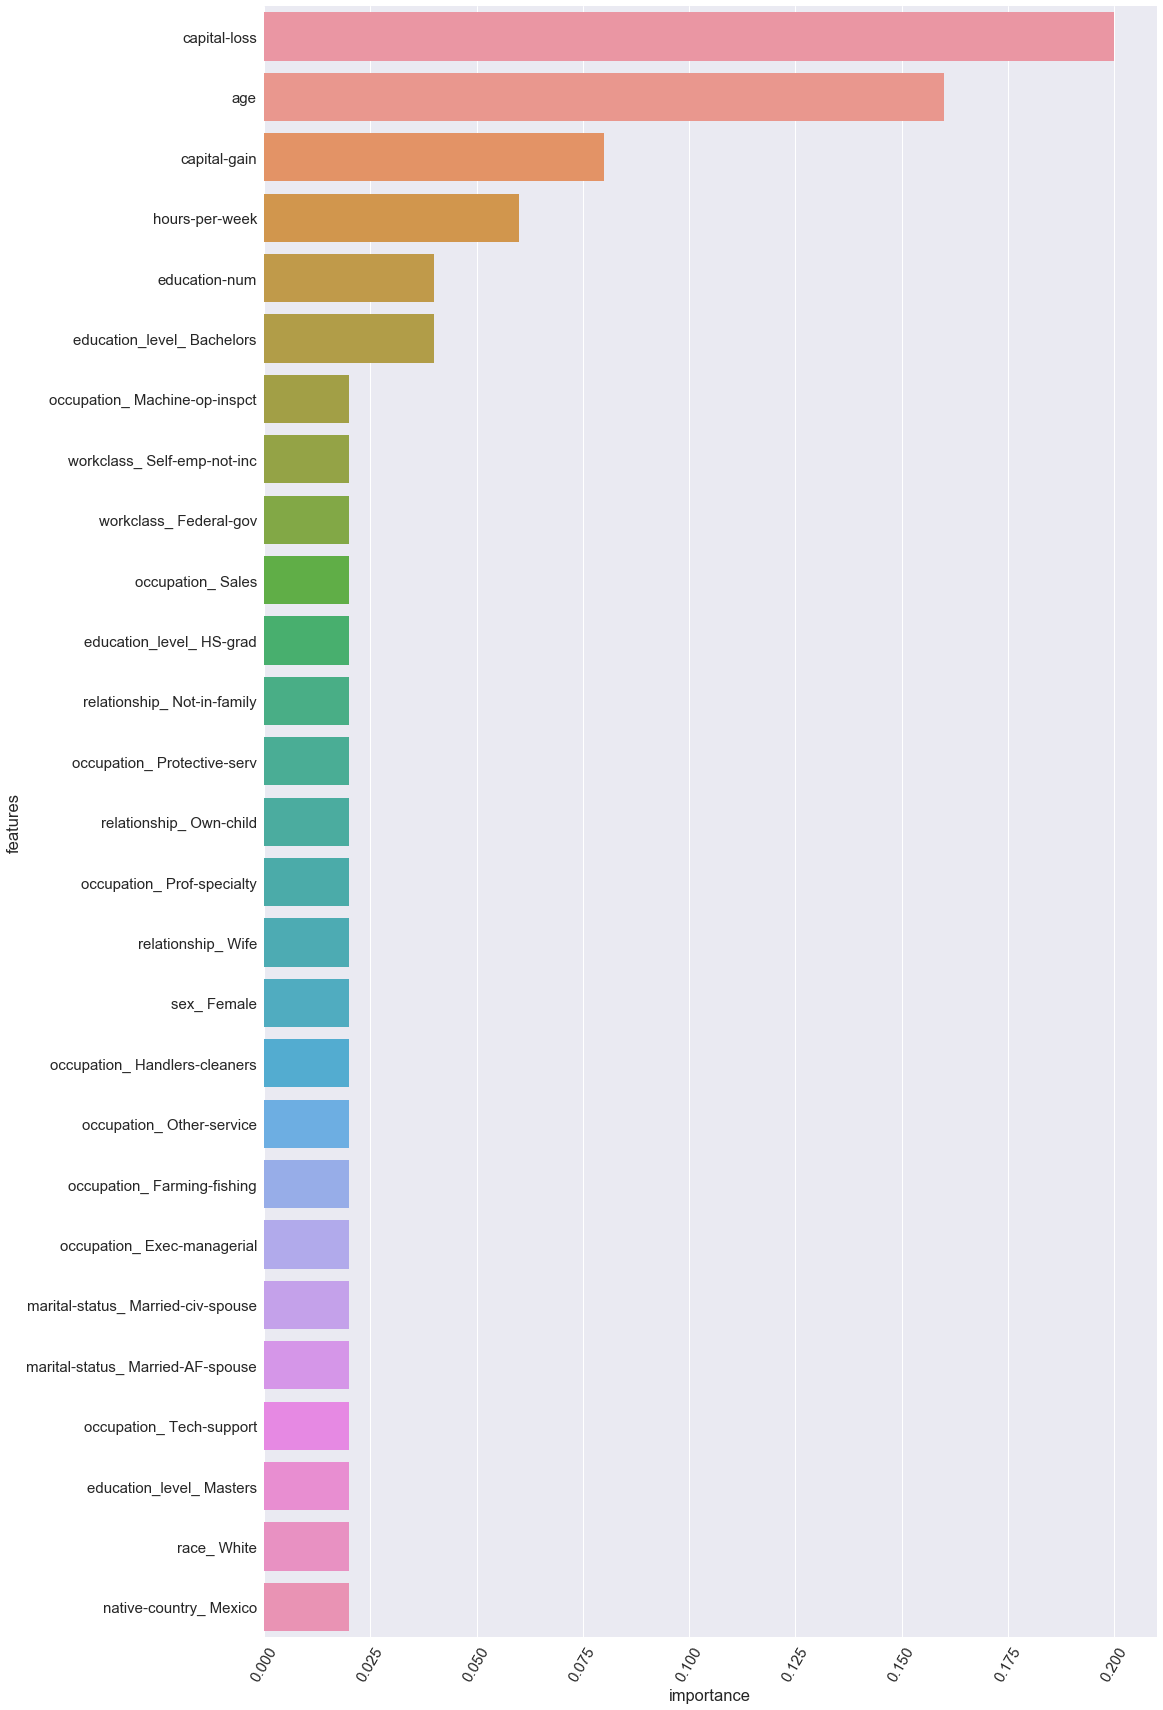

In [40]:
%%time

clf = AdaBoostClassifier(random_state = 0)
clf = clf.fit(X_train,y_train)
importances = clf.feature_importances_

max_features = np.count_nonzero(importances)

features = pd.DataFrame()
features['features'] = X_train.columns
features['importance'] = importances
features.sort_values(by=['importance'],ascending=False,inplace=True)

fig,ax= plt.subplots()
fig.set_size_inches(16,30)
plt.xticks(rotation=60)
sns.set(font_scale=2.5)
sns.barplot(data=features.head(max_features),x="importance",y="features",ax=ax) #,orient="v")
sns.set(font_scale=1.5)

X_train = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:max_features]]]
X_test = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:max_features]]]

print('Dataframe Shape (after dimensionality reduction):',X_train.shape)

## Model Pipeline

In [41]:
def train_predict(clf, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time()
    clf = clf.fit(X_train[:sample_size], y_train[:sample_size])
    results['train_time'] = time() - start
        
    start = time() 
    pred_train = clf.predict(X_train[:sample_size]) # 300
    pred_test = clf.predict(X_test)
    results['pred_time'] = time() - start
            
    results['acc_train'] = accuracy_score(y_train[:sample_size], pred_train) # 300
    results['acc_test'] = accuracy_score(y_test, pred_test)
    
    results['f_train'] = fbeta_score(y_train[:sample_size], pred_train, beta=0.5) # 300
    results['f_test'] = fbeta_score(y_test, pred_test, beta=0.5)
       
    print("{} trained on {} samples.".format(clf.__class__.__name__, sample_size))
        
    return results

## Model Evaluation (Initial)
- The Naive Predictor (Benchmark for results) is shown as a dashed horizontal line

RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


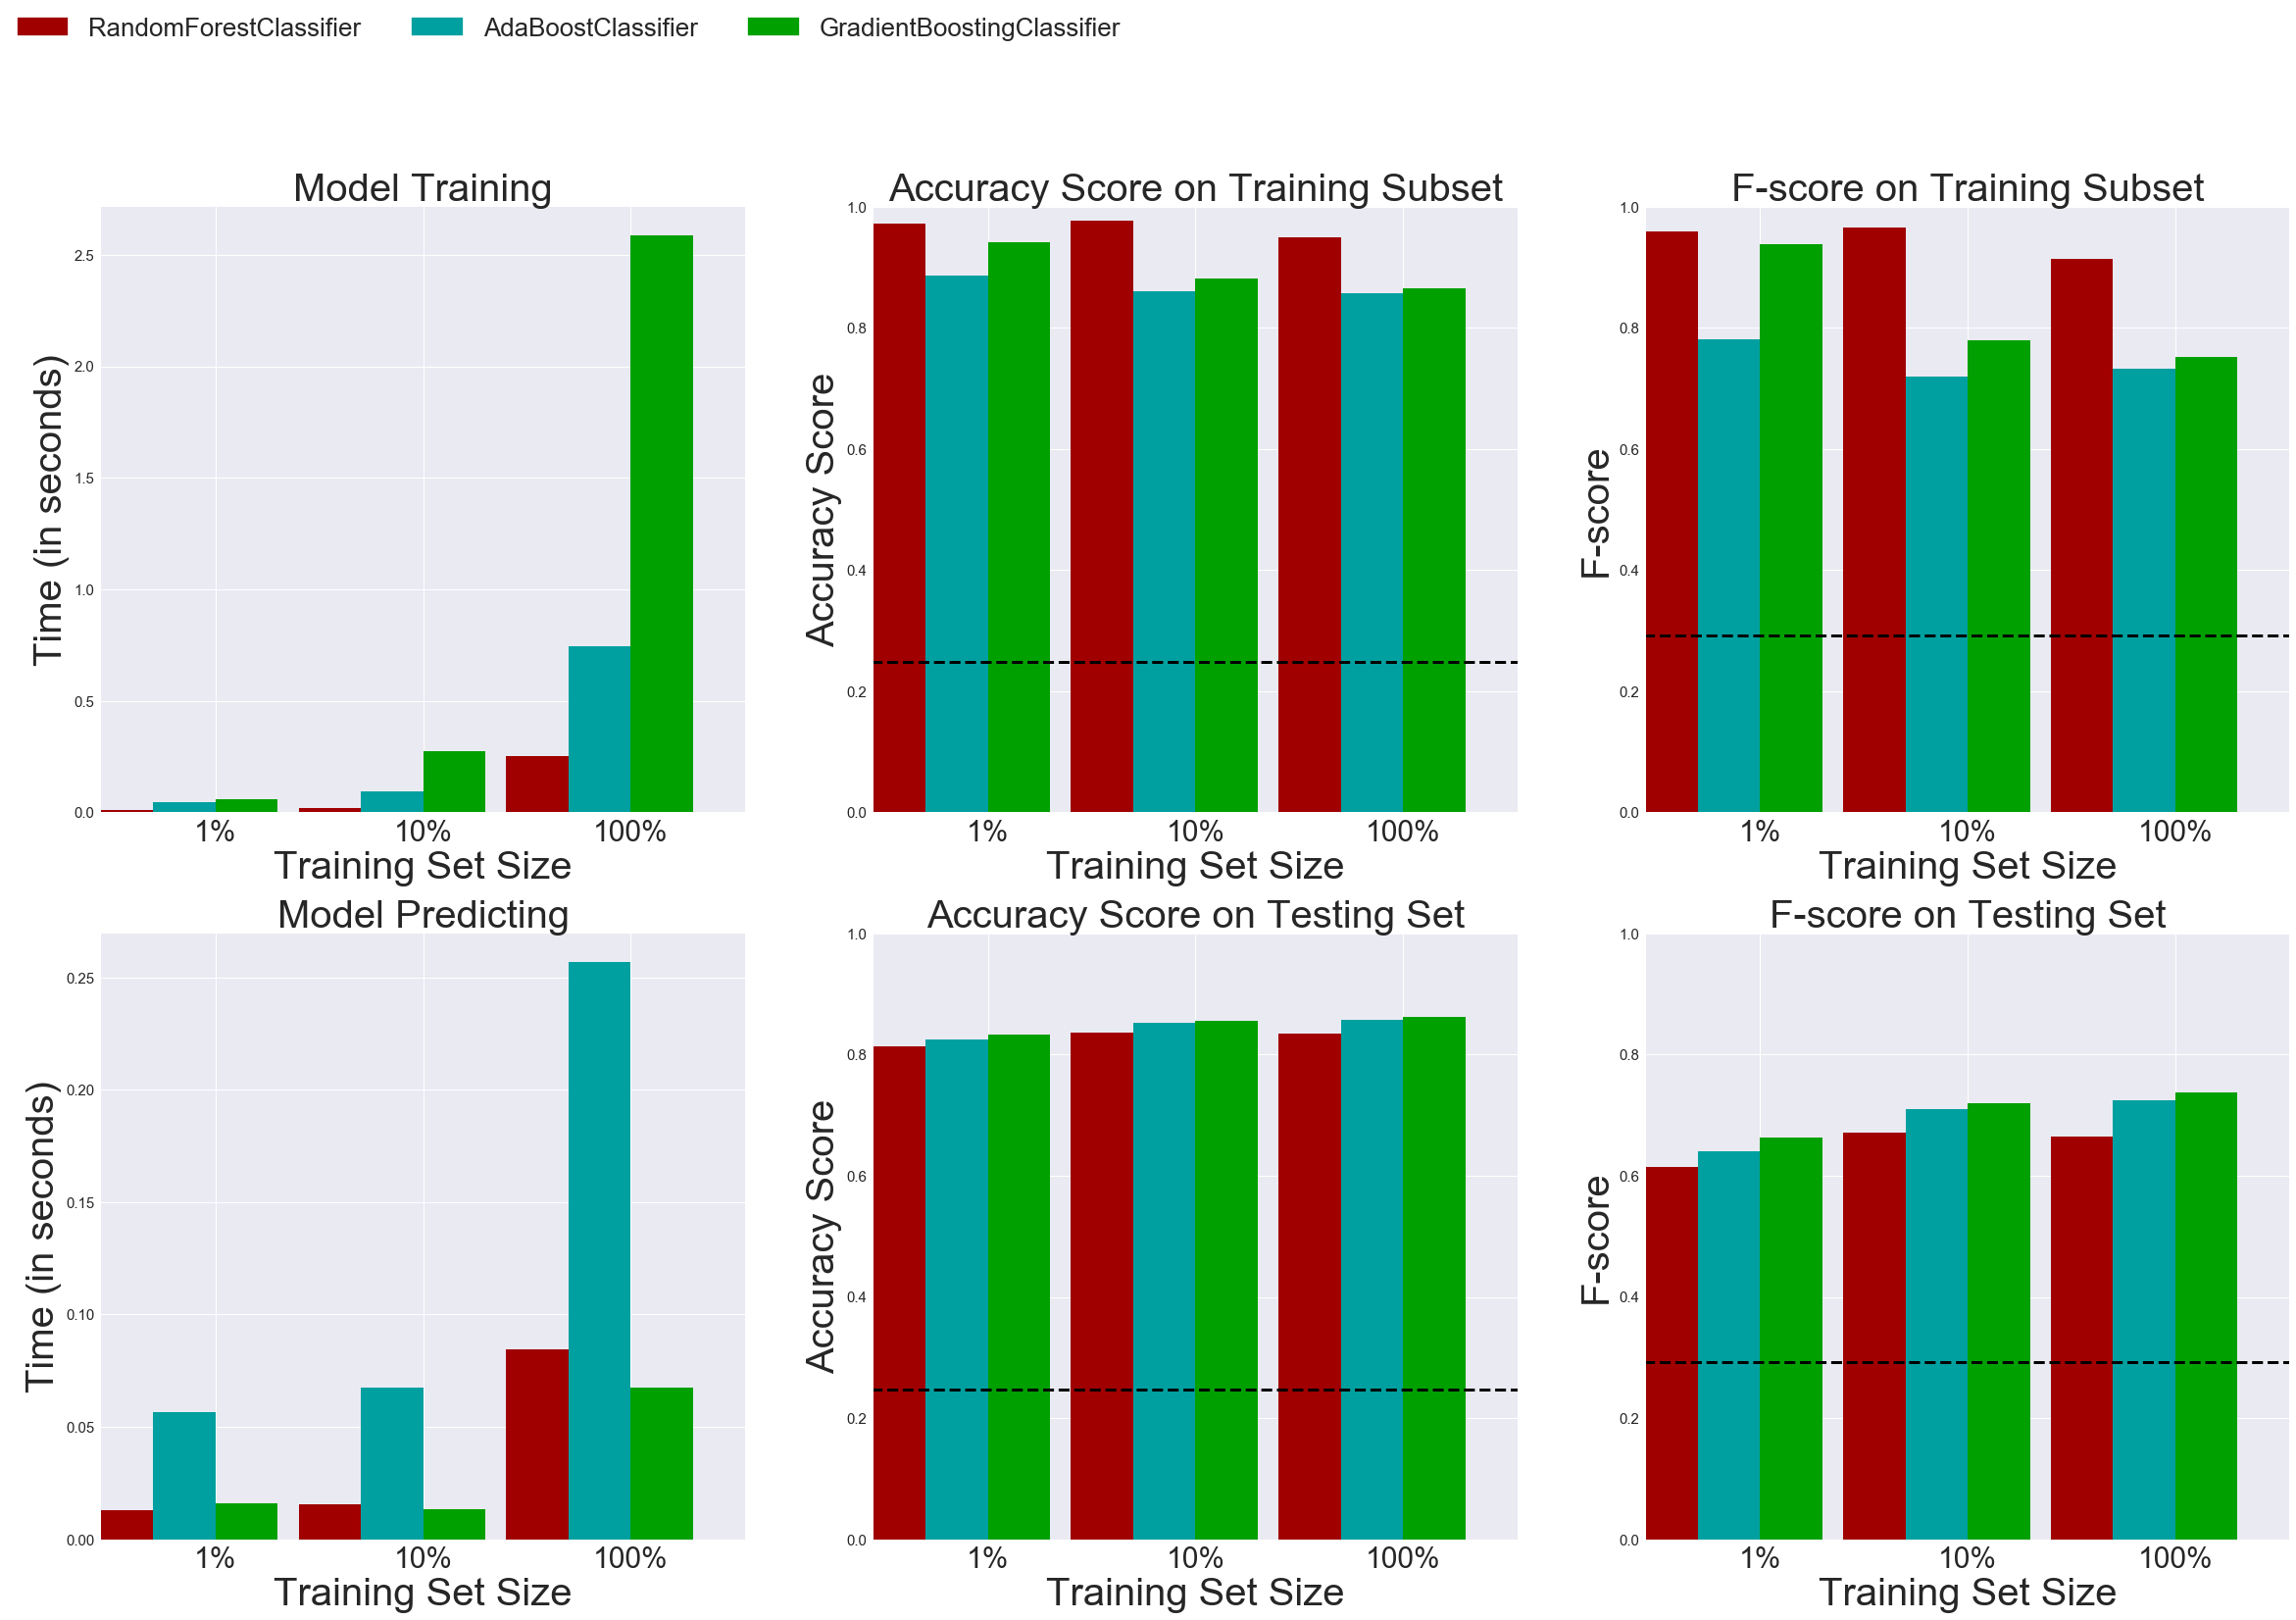

Wall time: 5.69 s


In [50]:
%%time

%run ./visuals.py

sns.set(font_scale=1.5)
clf_A = RandomForestClassifier(random_state = 0)
clf_B = AdaBoostClassifier()
clf_C = GradientBoostingClassifier(random_state = 0)

samples_100 = int(len(X_train))   # 100% sample
samples_10 = int(len(X_train)/10) # 10% sample
samples_1 = int(len(X_train)/100) # 1% sample

results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)

evaluate(results, accuracy, fscore)

## Choosing the Best Model

- The GradientBoostingClassifier will be the best model to use.
- It results in the highest F1 score for the Testing Set with 100% Training Data.
- The training time is somewhat slower than the other methods, but reasonably fast for the size of this dataset. 

## Describing the Model

- Gradient Boosting is a technique that creates a model uses an ensemble of weak prediction mdoels.
- The features are randomly permuted at each split. 
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

## Complexity Curves

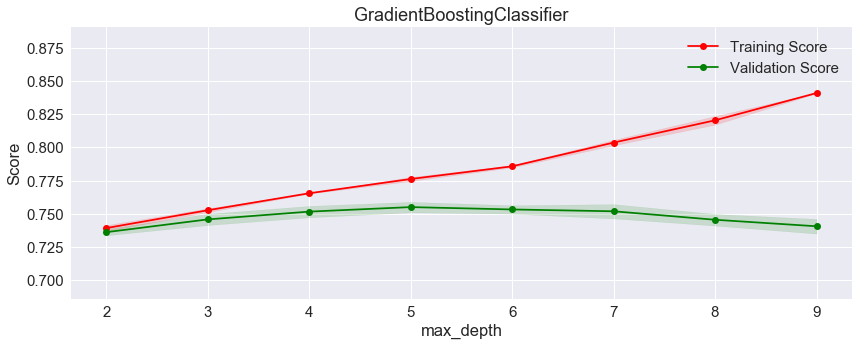

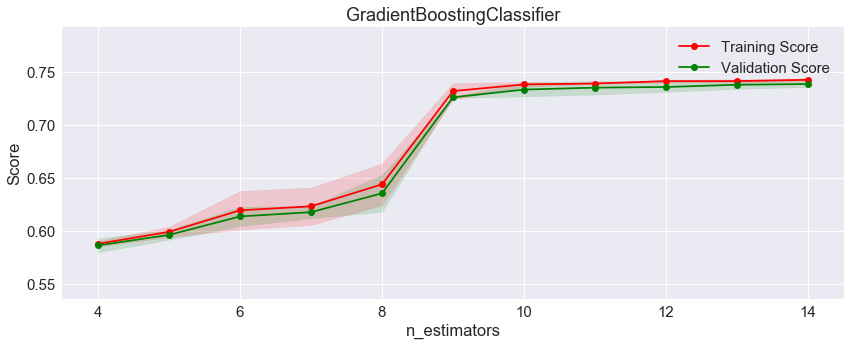

Wall time: 2min 27s


In [55]:
%%time

cv = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 0)

clf = GradientBoostingClassifier(random_state = 0)
ModelComplexity(X_train, y_train, clf, cv, scoring, 'max_depth', np.arange(2,10,1))

clf = GradientBoostingClassifier(max_depth = 5, random_state = 0)
ModelComplexity(X_train, y_train, clf, cv, scoring, 'n_estimators', np.arange(4,15,1))

## Model Tuning

In [56]:
%%time

def fit_model(X_train, y_train, X_test, clf, cv, scoring, param_grid):
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    predictions = (clf.fit(X_train, y_train)).predict(X_test)
    print("Unoptimized model\n------")
    print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
    
    grid = GridSearchCV(clf, param_grid=param_grid, scoring=scoring, cv=cv)
    grid = grid.fit(X_train, y_train)
    
    best_clf = grid.best_estimator_
    best_predictions = best_clf.predict(X_test)
    print("\nOptimized Model\n------")
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)),'\n')
    
    print(best_clf,'\n')
    return best_clf, best_predictions

cv = StratifiedShuffleSplit(n_splits = 3, test_size = 0.20, random_state = 0)
param_grid = {#'min_samples_leaf' : np.arange(1,20,5), 
              #'min_samples_split' : np.arange(2,60,15),
              'max_depth': np.arange(6,11,1),
              'n_estimators': np.arange(8,13,1)}

clf = GradientBoostingClassifier(random_state = 0) 
best_clf, best_predictions = fit_model(X_train, y_train, X_test, clf, cv, scoring, param_grid)

Unoptimized model
------
Accuracy score on testing data: 0.8626
F-score on testing data: 0.7378

Optimized Model
------
Final accuracy score on the testing data: 0.8600
Final F-score on the testing data: 0.7469 

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=12,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False) 

Wall time: 1min 43s


## Model Evaluation

### Final Results:


|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |   0.8626          | 0.8600          |
| F-score        |   0.7378          | 0.7469          |


## Feature Importance

**The feature importance ranking from Dimensionality Reduction suggests these as the 5 most important features:**
- Capital Loss - Higher capital loss suggests lower income
- Capital Gain - Higher capital gain suggests higher income
- Age - Higher age suggests higher income
- Education - More years of education suggests higher income
- Hours Per Week - More hours per week of work suggests higher income

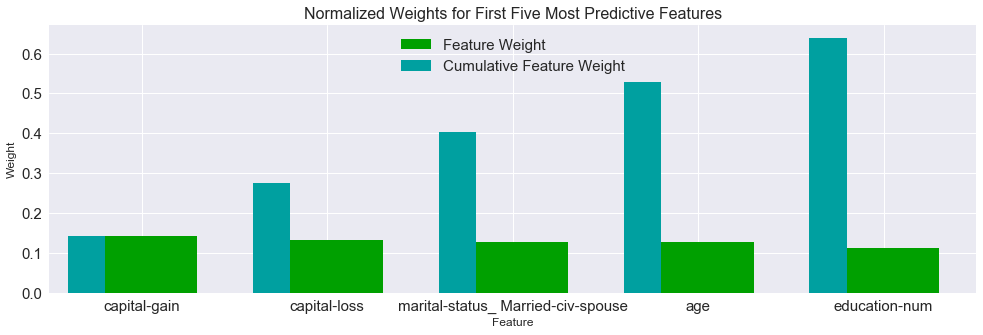

Wall time: 2.82 s


In [59]:
%%time

''' Feature Importance '''
clf = GradientBoostingClassifier(random_state = 0)
clf = clf.fit(X_train,y_train)
importances = clf.feature_importances_
feature_plot(importances, X_train, y_train)

## Feature Importance: Results

- The results are essentially the same, with the exception of Age vs Marrital Status.
- This makes sense, since complete families are usually in a better financial position for charity

## Feature Selection

In [63]:
''' Feature Selection '''
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

''' Train on the "best" model found from grid search earlier '''
clf = (clone(best_clf)).fit(X_train_reduced, y_train)
reduced_predictions = clf.predict(X_test_reduced)

print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8600
F-score on testing data: 0.7469

Final Model trained on reduced data
------
Accuracy on testing data: 0.8534
F-score on testing data: 0.7268


## Feature Selection: Effects

- The F-score goes down from 0.7469 to 0.7286 when reducing the number of features from 27 to 5
- The difference is only about 2%, so if training time was a factor this might be acceptable.
- RFECV is also another very effective method for optimal Feature Selection

## Sensitivity Analysis

In [74]:
%%time

def sensitivity_analysis(X_train, y_train, X_test, clf, cv, scoring, param_grid):
    
    grid = GridSearchCV(clf, param_grid=param_grid, scoring=scoring, cv=cv)
    grid = grid.fit(X_train, y_train)
    
    best_clf = grid.best_estimator_
    best_predictions = best_clf.predict(X_test)

    accuracy = accuracy_score(y_test, best_predictions)
    fbeta = fbeta_score(y_test, best_predictions, beta = 0.5)
    
    print ('Trial: {}, Accuracy: {:.4f}, F-score: {:.4f}'.format(k, accuracy, fbeta))
    #print("Final accuracy score on the testing data: {:.4f}".format(accuracy))
    #print("Final F-score on the testing data: {:.4f}".format(fbeta),'\n')
    
    return accuracy, fbeta

cv = StratifiedShuffleSplit(n_splits = 3, test_size = 0.20, random_state = 0)
param_grid = {#'min_samples_leaf' : np.arange(1,20,5), 
              #'min_samples_split' : np.arange(2,60,15),
              'max_depth': np.arange(6,11,1),
              'n_estimators': np.arange(8,13,1)}

acc_results, fbeta_results = [], []

for k in range(5):
    clf = GradientBoostingClassifier(random_state = k) 
    cv = StratifiedShuffleSplit(n_splits = 3, test_size = 0.20, random_state = k)
    accuracy, fbeta = sensitivity_analysis(X_train_reduced, y_train, X_test_reduced, clf, cv, scoring, param_grid)
    acc_results.append(accuracy)
    fbeta_results.append(fbeta)
    #print (k)

print ("\nRange in accuracy: {:,.4f}".format(max(acc_results) - min(acc_results)))
print ("Standard Deviation in accuracy: {:,.4f}".format(np.std(acc_results)))

print ("\nRange in fbeta: {:,.4f}".format(max(fbeta_results) - min(fbeta_results)))
print ("Standard Deviation in fbeta: {:,.4f}".format(np.std(fbeta_results)),'\n')

Trial: 0, Accuracy: 0.8536, F-score: 0.7269
Trial: 1, Accuracy: 0.8543, F-score: 0.7284
Trial: 2, Accuracy: 0.8534, F-score: 0.7267
Trial: 3, Accuracy: 0.8534, F-score: 0.7268
Trial: 4, Accuracy: 0.8533, F-score: 0.7264

Range in accuracy: 0.0010
Standard Deviation in accuracy: 0.0004

Range in fbeta: 0.0019
Standard Deviation in fbeta: 0.0007 

Wall time: 2min 10s
